This notebook requires the BioSCRAPE package (https://github.com/biocircuits/bioscrape). BioSCRAPE can be installed from source or with pip (`pip install bioscrape`).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import math
import copy
import os
from datetime import datetime
import pickle

import bioscrape as bs
import bioscrape.lineage as bs_lineage

import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
# sns.set(rc=rc)
# sns.set(style = "ticks")

sns.set_context('paper')

%matplotlib inline
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

three_colors = ["#1b9e77", "#d95f02","#7570b3"]
three_colors_light = ["#66c2a5", "#fc8d62", "#8da0cb"] 

# Summary

This notebook describes and simulates five different DNA replication models: a trivial replication model, a dummy replication trigger model, Brendel & Perelson's ColE1 replication model, a reduced three-species ColE1 repliation model, and a reduced one-species ColE1 replication model. We won't be using these models in a biocircuit here -- this notebook is just to show how the models work (or don't, in the case of the trivial model) on their own, with a single replicating DNA species.

Specifically we will:
* Describe the models.
* Show example trajectories of DNA replciating with each model using both standard SSA and lineage simulations that explicitly growth and cell division.
* Calculate (empirical) steady-state distributions of the replicating DNA species using each model.
* Fit steady-state distributions to empirical plasmid copy number distribution data.

For all models, we will assume a dilution rate (equivalently, cell growth rate) of $\gamma$. For SSA and deterministic simulations, this is equivalent to an implicit "dilution" reaction $DNA \overset{\gamma}{\to} \emptyset$; for lineage simulations, this simply means that cells will grow at average rate $\gamma$, with doubling time $\ln(2)/\gamma$. All simulations will be performed using BioSCRAPE.

*On notation*: In every model, we will define $DNA$ (initalics) as the free DNA species. We will also use $DNA$ to mean "concentration of $DNA$" ($[DNA]$) for simplicity of notation.

# 1) The Models

For all of our models, we'll want to be able to make both lineage model objects (i.e., in a growing cell, with tracked volume, that can divide) and non-lineage models (i.e., simulated with naked SSA with dilution rules $X\to \emptyset$ for each species). Making a lineage model requires some boilerplate code that's shared between all models, which we'll define here:

In [29]:
def make_growth_model(rxns, species, params, initial_conditions):
    '''
    Adds some scaffolding to a model to put it in an exponentially-growing cell 
    with growth rate params['k_gamma']. Parameters are of the same type and 
    specification as used by bioscrape.types.Model.
    '''
    m = bs_lineage.LineageModel(reactions = rxns, 
                                parameters = params,
                                species = species,
                                initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, but don't grow if there's 
    # no DNA present. This gives us selection against plasmid loss in lineage simulations.
    m.create_volume_rule("ode", {"equation": "volume * k_gamma * Heaviside(DNA-1)"})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial"},
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

## 1.1) Trivial Replication

The simplest, most intuitive model of DNA replication is one where each DNA molecule can spontaneously replicate:

$$DNA \overset{k_{rep}}{\to} DNA + DNA$$

In deterministic equation land, this model is described by 

$$\frac{dDNA}{dt} = k_{rep} DNA - \gamma DNA$$

For there to be a steady state solution to this ODE, we must have $k_{rep} = \gamma$. Notice that this implies that $DNA$ could have any value at steady state. 

This model has an extremely simple bioscrape implementation, and we'll only be using it in a non-lineage SSA setting, so we can keep the model quite simple.

In [3]:
def make_trivial_model(params, initial_conditions, lineage = False):
    rxns = [
        (['DNA'], ['DNA', 'DNA'], 'massaction', {'k': params['k_alpha']})
    ]
    if not lineage:
        rxns.append((['DNA'], [], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = ["DNA"], parameters = params, reactions = rxns, 
                initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, ["DNA"], params, initial_conditions)
        return m

## 1.2) Dummy Replication Trigger

The next-simplest replication model is:

\begin{align*}
    \emptyset &\xrightarrow{\alpha} R\\
    DNA + R &\xrightarrow{k_\text{fast}} DNA + DNA
\end{align*}

The idea here is to use zero-order production of a "dummy replication trigger" molecule $R$, which is quickly consumed to replicate one plasmid. This gets us zero-order replication against first-order dilution in a straightforward way. 

Note that the dummy replication trigger model has the convenient property of having an easy-to-compute steady state of approximately $\alpha / \gamma$, where $\gamma$ is the dilution rate.

In [4]:
def make_dummy_model(params, initial_conditions, lineage = False):
    rxns = [
        ([], ['R'], 'massaction', {'k': params['k_alpha']}),
        (['R', 'DNA'], ['DNA', 'DNA'], 'massaction', {'k':params['k_fast']})
    ]
    if not lineage:
        rxns.append((['DNA'], [], 'massaction', {'k':params['k_gamma']}))
        return bs.types.Model(species = ['DNA', 'R'], parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, ["R", "DNA"], params, initial_conditions)
        return m

## 1.3) Brendel & Perelson ColE1 Model

This is a mechanistic, biologically-plausible model originally devised by Brendel & Perelson (https://doi.org/10.1006/jmbi.1993.1092). In this model, ColE1 initiates replication by priming off of a cis-transcribed RNA (RNAII), which is then cleaved away to make room for DNA polymerase. ColE1 replication is limited by RNAI, which is also produced from ColE1, and which binds to RNAII to form a stable structure that cannot prime replication. The RNAI/II complex is eventually cleaved away from the plasmid, opening it up for potential replication again. 

There are several existing models of ColE1 replication in the literature:
* Keasling & Palsson, 1989, *Journal of Theoretical biology*: An ODE model emphasizing simplicity and estimability.
* Brendel & Perelson, 1992, *Journal of Molecular Biology*: Mechanistic CRN model including two-step elongation of RNAII and an optional sequestration pathway for low-copy maintenance using the Rom protein.
* Freudanau *et al*, 2015, *Frontiers in Bioengineering and Biotechnology* (https://doi.org/10.3389/fbioe.2015.00127): A re-analysis of Brendel & Perelson, with new experimental data an an additional set of reactions modeling regulation by uncharged tRNA.  

Here's the simpler (high-copy) version of the Brendel & Perelson model, as described in their paper (left) and in Freudanau *et al* (right):

<img src="resources/old_model_orig.png" alt="Drawing" style="height: 300px;"/>  <img src="resources/old_model.jpg" alt="Drawing" style="height: 300px;"/>

The reactions outside the blue box involve tRNA regulation, which we will ignore. the reactions in the red box are for Rom interaction, which lowers the copy number of the plasmid. These, we will also ignore. 

Let
* $DNA$: Free plasmid.
* $DNA_{RIIs}$: Plasmid with short transcribed RNAII.
* $DNA_{RIIL}$: Plasmid with long transcribed RNAII.
* $DNA_p$: Plasmid primed for replication.
* $RI$: Free RNAI.
* $DNA_{II:I_u}$: Plasmid with RNAII transiently ("unstable") bound to RNAI.
* $DNA_{II:I_s}$: Plasmid with RNAII firmly ("stable") bound to RNAI.

This gives us the following reactions:

\begin{align*}
    DNA &\overset{k_{II}}{\to} DNA_{RIIs}\\
    DNA_{RIIs} &\overset{k_l}{\to} DNA_{RIIL}\\
    DNA_{RIIL} &\overset{k_{-l}}{\to} DNA\\
    DNA_{RIIL} &\overset{k_p}{\to} DNA_p\\
    DNA_p &\overset{k_D}{\to} DNA + DNA\\
    DNA_{RIIs} + RI &\underset{k_{-1}}{\overset{k_1}{\rightleftharpoons}} DNA_{II:I_u}\\
    DNA_{II:I_u} &\underset{k_{-2}}{\overset{k_2}{\rightleftharpoons}} DNA_{II:I_s}\\
    DNA_{II:I_s} &\overset{k_{-c}}{\to} DNA\\
    \text{(not shown, but necessary)}\\
    DNA &\overset{k_I}{\to} DNA + RI\\
    RI &\overset{\gamma_I + \gamma}{\to} \emptyset\\
    DNA &\overset{\gamma}{\to} \emptyset \text{  (etc. for each plasmid species)}\\
\end{align*}

Note that Brendel & Perelson only include a reaction for RI production from *free plasmid*. This looks odd at first glance, but is actually reasonable because both promoter and sequence of RNAI are contained *within the RNAII sequence*. Practically, this is unlikely to be an important detail, as with the parameters reported by Brendel & Perelson, the vast majority of DNA is in its free state at any particular time.  

In [5]:
# These are the parameters reported in the original B&P paper, with division
# time set to 30 minutes. Units are in terms of nM and minutes; we're playing
# a little fast and loose by implicitly assuming an E. coli volume fixed such
# that 1 copy/cell = 1 nM. 
bp_default_params = {
        "k_II": 0.25,
        "k_L": 12.0,
        "k_mL": 4.3,
        "k_p": 4.3,
        "k_D": 5,
        "k_1": 0.15, # 1/nM
        "k_m1": 48,
        "k_2": 44,
        "k_m2": 0.085,
        "k_mC": 17,
        "k_I": 6,
        "k_gamma_I": .35,
        "k_gamma": math.log(2)/30 # 30 min division time
    }

# The same parameters, but nondimensionalized so that division time = 1
bp_nondim_params = {param: val/(bp_default_params['k_gamma']) for (param,val) in bp_default_params.items()}

def make_BP_model(params, initial_conditions, lineage = False):
    plasmid_species = ["DNA", "DNA_RIIs", "DNA_RIIL", "DNA_p", "DNA_II_Iu", "DNA_II_Is"]
    species = plasmid_species + ["RI"]

    reactions = [
        (["DNA"], ["DNA_RIIs"], "massaction", {"k": "k_II"}),
        (["DNA"], ["DNA", "RI"], "massaction", {"k": "k_I"}),
        (["DNA_RIIs"], ["DNA_RIIL"], "massaction", {"k": "k_L"}),
        (["DNA_RIIL"], ["DNA"], "massaction", {"k": "k_mL"}),
        (["DNA_RIIL"], ["DNA_p"], "massaction", {"k": "k_p"}),
        (["DNA_p"], ["DNA", "DNA"], "massaction", {"k": "k_D"}),
        (["DNA_RIIs", "RI"], ["DNA_II_Iu"], "massaction", {"k": "k_1"}),
        (["DNA_II_Iu"], ["DNA_RIIs", "RI"], "massaction", {"k": "k_m1"}),
        (["DNA_II_Iu"], ["DNA_II_Is"], "massaction", {"k": "k_2"}),
        (["DNA_II_Is"], ["DNA_II_Iu"], "massaction", {"k": "k_m2"}),
        (["DNA_II_Is"], ["DNA"], "massaction", {"k": "k_mC"}),
        (["RI"], [], "massaction", {"k": "k_gamma_I"})
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"k": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m

## 1.4) Three-Species Reduced Brendel & Perelson ColE1 Model

The Brendel & Perelson ColE1 model has a fair number of moving parts, but conceptually boils down to two loops modulated by the presence of RI -- a productive loop that leads to a replication, and a non-productive loop that eats up an RI instead. We may be able to get away with a simplified B&P model that isn't quite as mechanistically accurate but has the same conceptual structure:

<img src="resources/3s_bp_diagram.png" alt="Drawing" style="height: 200px;"/>

Here $DNA$ is plasmid, $DNA_p$ is plasmid attempting to replicate (with **p**olymerase) and $R$ is free RNAI: 

\begin{align*}
    DNA &\overset{k_p}{\to} DNA_p\\
    DNA_p &\overset{k_{rep}}{\to} DNA + DNA\\
    DNA &\overset{k_{tx}}{\to} DNA + R\\
    DNA_p + R &\overset{k_I}{\to} DNA\\
    DNA &\overset{\gamma}{\to} \emptyset\\
    DNA_p &\overset{\gamma}{\to} \emptyset\\
    R &\overset{\gamma_I + \gamma}{\to} \emptyset\\
\end{align*}

In this model, plasmids enter a "trying to replicate" state before replicating; during this state, an RNAI molecule can annihiliate itself in order to cancel the replication.

In [47]:
def make_three_species_BP_model(params, initial_conditions, lineage = False):
    species = ["DNA", "DNAp", "R"]

    reactions = [
        (["DNA"], ["DNAp"], "massaction", {"k": "k_p"}),
        (["DNAp"], ["DNA", "DNA"], "massaction", {"k": "k_rep"}),
        (["DNA"], ["DNA", "R"], "massaction", {"k": "k_tx"}),
        (["DNAp", "R"], ["DNA"], "massaction", {"k": "k_I"}),
        (["R"], [], "massaction", {"k": "k_gamma_I"})
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"k": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m
    
def make_qss_three_species_BP_model(params, initial_conditions, lineage = False, 
                                  force_approximation = False, verbose = False):
    '''Speed-optimized version using a quasi-steady state assumption on R.
    
    Parameters:
        params - Dictionary of parameters for the mode, as in make_three_species_BP_model.
        initial_conditions - Dictionary of initial conditions, as in make_three_species_BP_model.
        lineage - If true, makes a model appropriate for a lineage simulation. 
        force_approximation - If true, forces quasi-steady state approximation of 
                                R. Otherwise, will check that the expected rate of 
                                reactions involved in producing and destroying R is 
                                fast compared to the rate of reactions that use R for 
                                feedback control; if R's population dynamics are slow,
                                then the quasi-steady state assumption will not be used
                                (and probably wouldn't speed things up much anyway).
    '''
    if params["k_p"] < params["k_rep"]:
        # Regime of rare DNAp
        expected_DNAp = 1
        expected_DNA = params['k_rep'] * (params['k_p'] - params['k_gamma']) \
                      * (params['k_gamma'] + params['k_gamma_I'])\
                      / params['k_tx'] / params['k_I'] / params['k_gamma']
        expected_R = expected_DNA * params['k_tx'] / (params['k_gamma'] + params['k_gamma_I'])
    else:
        expected_DNAp = params["k_p"] * (params["k_gamma"]+params["k_gamma_I"]) \
                        / (params["k_tx"] - params['k_p']) / params["k_I"]
        expected_DNA = expected_DNAp * params['k_rep'] / params['k_gamma']
        expected_R = expected_DNA * params['k_tx'] / (params['k_gamma'] + params['k_gamma_I'] + expected_DNAp * params['k_I'])
    
    r_dynamics_rate = 2 * expected_DNA * params['k_tx']
    r_use_rate = params['k_I'] * expected_DNAp * expected_R #* params['k_tx']
    
    if not force_approximation and r_dynamics_rate < r_use_rate:
        # No point in approximating quasi-steady state for R, since 
        # computing how R is used will take at least as much time 
        # as computing R's population exactly.
        if verbose:
            print("Quasi-steady state approximation would not speed up three-species model, " 
                  "falling back to non-quasi steady state version.")
        return make_three_species_BP_model(params, initial_conditions, lineage)
    
    species = ["DNA", "DNAp"]

    reactions = [
        (["DNA"], ["DNAp"], "massaction", {"k": "k_p"}),
        (["DNAp"], ["DNA", "DNA"], "massaction", {"k": "k_rep"}),
        # Here's where the quasi-steady state approximation happens.
        (["DNAp",], ["DNA"], "general", {"rate": "DNAp * k_I * DNA * k_tx / (k_gamma + k_gamma_I + k_I*DNAp)"})
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"rate": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m

# 1.5) One-species Reduced Brendel & Perelson ColE1 Model

Finally, with some further simplifying assumptions, we can reduce the Brendel & Perelson ColE1 model down to a single DNA species with a Hill-function replication propensity (with respct to its own concentration). See the "`simple_bp_model_reduction.ipynb`" notebook for details. Specifically, for this model to be a good approximation of the three-species model, we need to assume:
* $k_{rep} > k_p$
* $R$ dynamics are fast, and $R$ comes to instantaneous steady state.
* Concentration of $R$ is not affected much by the $DNA_p + R \to DNA$ reaction (i.e., there's not much $DNA_p$ sticking around and $R$ creation/destruction dynamics are fast).

If these are true, then we can approximate the three-species model by 

\begin{align*}
DNA &\xrightarrow{H(DNA)} DNA + DNA\\
DNA &\xrightarrow{\gamma} \emptyset
\end{align*}

where

\begin{align*}
H(DNA) &= \frac{k_p}{1 + \beta DNA}\\
\beta &= \frac{k_I k_{tx}}{k_{rep}(\gamma + \gamma_I)}
\end{align*}

For convenience, we'll make the model-producing function take either the two parameters $k_p$ and $\beta$, or take all of the parameters of the three-species model.

In [7]:
def make_one_species_BP_model(params, initial_conditions, lineage = False):
    species = ["DNA"]

    if "k_beta" in params:
        beta = "k_beta"
    else:
        gamma_tot = "k_gamma + k_gamma_I"
        beta = f"(k_I * k_tx / k_rep / ({gamma_tot}))"
    rep_rate = f"DNA * k_p / (1 + {beta} * DNA)"
    reactions = [
        (["DNA"], ["DNA", "DNA"], "general", {"rate": rep_rate}),
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"k": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m

# 2) Example Trajectories

Example trajectories of a naked DNA in SSA simulation, with no other circuit to worry about.

## 2.1) Trivial Replication Trajectories

In [9]:
cell_start_time = datetime.now()

default_trivial_params = {
    "k_gamma": 1,
    "k_alpha": 1
}
inits = {"DNA": 50}
trivial_model = make_trivial_model(default_trivial_params, inits)
ts = np.linspace(0, 300, 1000)
n_sims = 50

# Required for replicability
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)
trivial_results = [bs.simulator.py_simulate_model(ts, Model = trivial_model, stochastic = True) \
                   for i in range(n_sims)]

cell_end_time = datetime.now()
print(f"Execution time: {cell_end_time - cell_start_time}")

Execution time: 0:00:00.212126


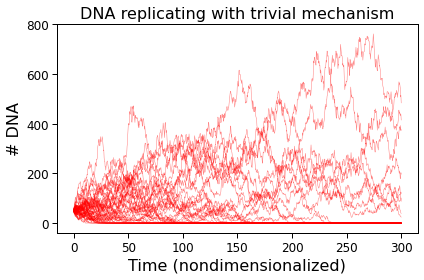

In [10]:
plt.plot(ts, np.array([sim['DNA'] for sim in trivial_results]).T, 
         color = 'red', lw = 0.5, alpha = .5)
plt.title("DNA replicating with trivial mechanism", fontsize = 16)
plt.xlabel("Time (nondimensionalized)", fontsize = 16)
plt.ylabel("# DNA", fontsize = 16)
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "trivial_mech_ssa.png"), dpi=300)
plt.show()

Here's the trivial mechanism with several different initial conditions:

In [11]:
default_trivial_params = {
    "k_gamma": 1,
    "k_alpha": 1
}
cell_start_time = datetime.now()

inits = np.linspace(1, 100, 10)
multiinit_det_results = []
multiinit_stoch_results = []
ts = np.linspace(0, 150, 1000)
# Required for replicability
seed = 42336
np.random.seed(seed)
bs.random.py_seed_random(seed)
for i, init_DNA in enumerate(inits):
    temp_trivial_model = make_trivial_model(default_trivial_params, {"DNA": int(init_DNA)})
    multiinit_det_results.append(bs.simulator.py_simulate_model(ts, Model = temp_trivial_model, stochastic = False))
    multiinit_stoch_results.append(bs.simulator.py_simulate_model(ts, Model = temp_trivial_model, stochastic = True))

cell_end_time = datetime.now()
print(f"Execution time: {cell_end_time - cell_start_time}")

Execution time: 0:00:00.058554


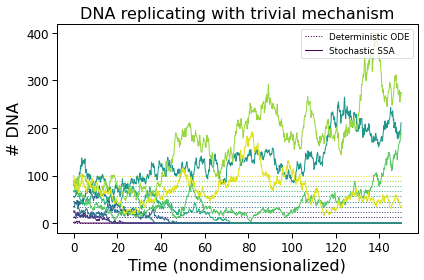

In [12]:
viridis_colors = plt.cm.viridis(np.linspace(0, .95, len(inits)))
plt.gca().set_prop_cycle('color', viridis_colors)
for i in range(len(inits)):
    plt.plot(ts, multiinit_det_results[i]["DNA"], 
             lw = 1, ls = ":", label = "Deterministic ODE" if i==0 else None)
for i in range(len(inits)):
    plt.plot(ts, multiinit_stoch_results[i]["DNA"], 
              lw = 1, ls = "-", label = "Stochastic SSA" if i==0 else None)
# plt.plot(ts[start:end], np.array([sim['DNA'] for sim in multiinit_stoch_results]).T[start:end,9], 
#          color = 'red', lw = 1, ls = "-", label = "Stochastic SSA, #9")
plt.title("DNA replicating with trivial mechanism", fontsize = 16)
plt.xlabel("Time (nondimensionalized)", fontsize = 16)
plt.ylabel("# DNA", fontsize = 16)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "trivial_multiple_inits.pdf"), dpi = 300)
plt.show()

## 2.2) Dummy Replication Trigger Trajectories

In [13]:
cell_start_time = datetime.now()

default_dummy_params = {
    "k_gamma": 1,
    "k_alpha": 50,
    "k_fast": 100
}
inits = {"DNA": 50}
dummy_model = make_dummy_model(default_dummy_params, inits)
ts = np.linspace(0, 50, 1000)
n_sims = 50

# Required for replicability
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)
dummy_results = [bs.simulator.py_simulate_model(ts, Model = dummy_model, stochastic = True) \
                   for i in range(n_sims)]
dummy_det_results = bs.simulator.py_simulate_model(ts, Model = dummy_model, stochastic = False)

cell_end_time = datetime.now()
print(f"Execution time: {cell_end_time - cell_start_time}")

Execution time: 0:00:00.102431


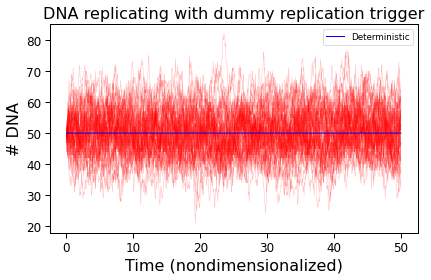

In [14]:
plt.plot(ts, np.array([sim['DNA'] for sim in dummy_results]).T, 
         color = 'red', lw = 0.5, alpha = .25)
plt.plot(ts, dummy_det_results['DNA'], color = 'blue', lw = 1, label = "Deterministic")
plt.legend()
plt.title("DNA replicating with dummy replication trigger", fontsize = 16)
plt.xlabel("Time (nondimensionalized)", fontsize = 16)
plt.ylabel("# DNA", fontsize = 16)
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "dummy_mech_ssa.png"), dpi=300)
plt.show()

In [15]:
cell_start_time = datetime.now()

inits = np.linspace(1, 100, 10)
ts = np.linspace(0, 10, 1000)

# Required for replicability
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)
dummy_stoch_results = []
dummy_det_results = []
for i, init_DNA in enumerate(inits):
    temp_dummy_model = make_dummy_model(default_dummy_params, {"DNA": init_DNA})
    dummy_stoch_results.append(bs.simulator.py_simulate_model(ts, Model = temp_dummy_model, stochastic = True))
    dummy_det_results.append(bs.simulator.py_simulate_model(ts, Model = temp_dummy_model, stochastic = False))

cell_end_time = datetime.now()
print(f"Execution time: {cell_end_time - cell_start_time}")


Execution time: 0:00:00.041242


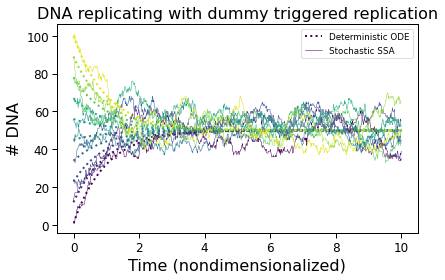

In [16]:
viridis_colors = plt.cm.viridis(np.linspace(0, .95, len(inits)))
plt.gca().set_prop_cycle('color', viridis_colors)
for i in range(len(inits)):
    plt.plot(ts, dummy_det_results[i]["DNA"], 
             lw = 2, ls = ":", label = "Deterministic ODE" if i==0 else None)
for i in range(len(inits)):
    plt.plot(ts, dummy_stoch_results[i]["DNA"], 
              lw = .5, alpha = 1, ls = "-", label = "Stochastic SSA" if i==0 else None)
# plt.plot(ts[start:end], np.array([sim['DNA'] for sim in multiinit_stoch_results]).T[start:end,9], 
#          color = 'red', lw = 1, ls = "-", label = "Stochastic SSA, #9")
plt.title("DNA replicating with dummy triggered replication", fontsize = 16)
plt.xlabel("Time (nondimensionalized)", fontsize = 16)
plt.ylabel("# DNA", fontsize = 16)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "dummy_multiple_inits.png"), dpi = 300)
plt.savefig(os.path.join("results", "dummy_multiple_inits.pdf"), dpi = 300)
plt.show()

## 2.3) Brendel & Perelson Trajectories

Note that we're using the nondimensionalized version of B&P's reported parameter set.

In [17]:
cell_start_time = datetime.now()

inits = {"DNA": 50}
bp_model = make_BP_model(bp_nondim_params, inits)
ts = np.linspace(0, 50, 1000)
n_sims = 50

# Required for replicability
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)
bp_results = [bs.simulator.py_simulate_model(ts, Model = bp_model, stochastic = True) \
                   for i in range(n_sims)]
bp_det_results = bs.simulator.py_simulate_model(ts, Model = bp_model, stochastic = False)

cell_end_time = datetime.now()
print(f"Execution time: {cell_end_time - cell_start_time}")

Execution time: 0:00:13.877524


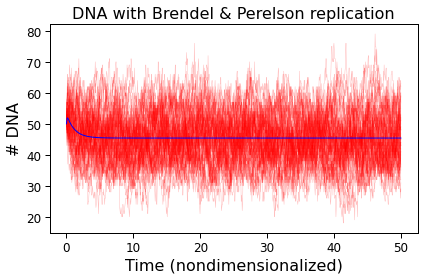

In [18]:
plt.plot(ts, np.array([sim['DNA'] for sim in bp_results]).T, 
         color = 'red', lw = 0.5, alpha = .25)
plt.plot(ts, bp_det_results['DNA'], color = 'blue', lw = 1)
plt.title("DNA with Brendel & Perelson replication", fontsize = 16)
plt.xlabel("Time (nondimensionalized)", fontsize = 16)
plt.ylabel("# DNA", fontsize = 16)
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "bp_mech_ssa.png"), dpi=300)
plt.show()

Note how much longer this takes to simulate than the simpler models!

## 2.4) Three-Species Brendel & Perelson Trajectories

In order to simulate a three-species B&P model that's "comparable" to the full B&P model, we'll want a set of parameters that matches the (nondimensionalized) B&P parameters decently well. We could fiddle with this by hand, or find parameters that give the same steady state, but the most direct way to get a good parameter set is to simply fit the model against a simulated trajectory from the full B&P model. 

We already have some simulated data from the full model, from above. Here are the first 50 divisions:

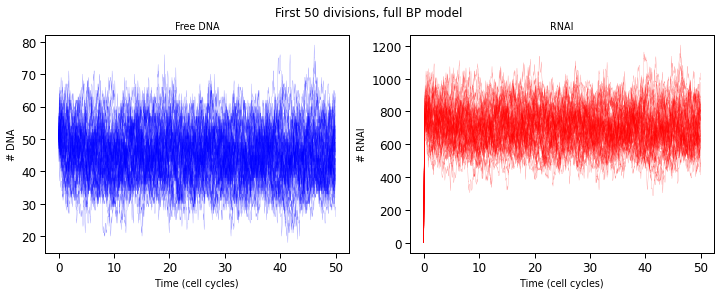

In [19]:
t_idx = np.argmax(ts>=50)
first_50_ts = ts[:t_idx]
bp_target_DNA = np.array([sim['DNA'][:t_idx] for sim in bp_results]).T
bp_target_RNA = np.array([sim['RI'][:t_idx] for sim in bp_results]).T

plt.figure(figsize = (12,4))
plt.suptitle("First 50 divisions, full BP model")
plt.subplot(121)
plt.plot(first_50_ts, bp_target_DNA, color = 'blue', lw = 0.25, alpha = 0.5)
plt.xlabel("Time (cell cycles)")
plt.ylabel("# DNA")
plt.title("Free DNA")
plt.subplot(122)
plt.plot(first_50_ts, bp_target_RNA, color = 'red', lw = 0.25, alpha = 0.5)
plt.xlabel("Time (cell cycles)")
plt.ylabel("# RNAI")
plt.title("RNAI")
plt.show()

We can use scipy to fit the three-species BP model against this data. For computational simplicity (and sanity), we'll simulate deterministically and fit with least-squared error against "empirical" simulations. Also for simplicity, we're going to fit only against the *free* DNA concentration (practically speaking, this is very, very close to *total* DNA concentration) and free RNAI.

In [20]:
param_guesses = {
    'k_rep' : 10, # Total guess
    'k_tx' : bp_nondim_params["k_I"], # Corresponds roughly to k_I
    'k_I' : min(bp_nondim_params["k_1"], bp_nondim_params["k_2"])/10, # Corresponds roughly to the slower of k_1 and k_2
    'k_p' : 20, # Very much guessing that this should be faster than k_rep, to give RNAI time to work.
    "k_gamma_I": bp_nondim_params["k_gamma_I"], # Is directly gamma_I from other model
}
true_gamma = 1 # This value is fixed at 1.

param_names = list(param_guesses.keys())
param_init_list = [param_guesses[k] for k in param_names]

species_inits = {
    "DNA": 50.0,
    "R": 0.0,
    "DNAp": 0.0
}

def cole1_residuals(param_list):
    param_dict = {param_names[i]: param_list[i] for i in range(len(param_list))}
    param_dict["k_gamma"] = true_gamma
    m = make_three_species_BP_model(param_dict, species_inits, lineage = False)
    temp_model_results = bs.simulator.py_simulate_model(first_50_ts, Model = m)
    temp_DNA = (temp_model_results["DNA"]+temp_model_results["DNAp"]).to_numpy()
    temp_free_RNA = temp_model_results["R"].to_numpy()
    dna_residuals = np.subtract(temp_DNA, bp_target_DNA.T).flatten()
    rna_residuals = np.subtract(temp_free_RNA, bp_target_RNA.T).flatten()
    return np.concatenate((dna_residuals, rna_residuals))

opt_start_time = datetime.now()

sol = scipy.optimize.least_squares(cole1_residuals, param_init_list, bounds = (0, np.inf),
                                   x_scale = [10, 100, 1, 1, 10])
opt_param_list = sol.x
fit_simple_bp_params = {param_names[i]: opt_param_list[i] for i in range(len(opt_param_list))}
fit_simple_bp_params["k_gamma"] = true_gamma
opt_end_time = datetime.now()
print(f"Execution time: {opt_end_time - opt_start_time}")

Execution time: 0:00:01.012835


In [21]:
print(f"{'Parameter':10}\t{'Init. Guess':10}\t{'Inferred Value':10}")
for param in fit_simple_bp_params:
    if param == "k_gamma":
        continue
    print(f"{param:10}\t{param_guesses[param]:10f}\t{fit_simple_bp_params[param]:10f}")
print(f"{'k_gamma':10}\t{bp_nondim_params['k_gamma']:10}\tN/A")

Parameter 	Init. Guess	Inferred Value
k_rep     	 10.000000	 16.126457
k_tx      	259.685107	275.329941
k_I       	  0.649213	  0.695778
k_p       	 20.000000	 33.330187
k_gamma_I 	 15.148298	 14.327573
k_gamma   	       1.0	N/A


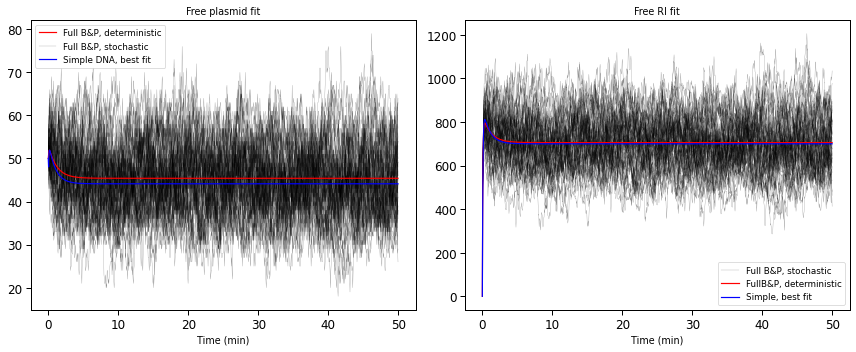

In [22]:
# Simulate out with best params and plot so we can visually check fit.
three_species_m = make_three_species_BP_model(fit_simple_bp_params, species_inits, lineage = False)
three_species_bp_det_results = bs.simulator.py_simulate_model(first_50_ts, Model = three_species_m)
full_bp_det_results = bs.simulator.py_simulate_model(first_50_ts, Model = bp_model)
plt.figure(figsize = (12, 5))

plt.subplot(121)
plt.title("Free plasmid fit")
plt.plot(first_50_ts, bp_target_DNA, label = "Full B&P, stochastic", color = "black", lw = 0.25, alpha = 0.5)
plt.plot(first_50_ts, full_bp_det_results["DNA"], label = "Full B&P, deterministic", color = "red")
plt.plot(first_50_ts, three_species_bp_det_results["DNA"], label = "Simple DNA, best fit", color = "blue")
plt.xlabel("Time (min)")
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.subplot(122)
plt.title("Free RI fit")
plt.plot(first_50_ts, bp_target_RNA, label = "Full B&P, stochastic", color = "black", lw = 0.25, alpha = 0.5)
plt.plot(first_50_ts, full_bp_det_results["RI"][:len(first_50_ts)], label = "FullB&P, deterministic", 
         color = "red")
plt.plot(first_50_ts, three_species_bp_det_results["R"], label = "Simple, best fit", color = "blue")
plt.xlabel("Time (min)")
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.tight_layout()
plt.show()

And here are stochastic trajectories of the three-species B&P model with those parameters:

In [23]:
cell_start_time = datetime.now()

inits = {"DNA": 50}
three_species_bp_model = make_three_species_BP_model(fit_simple_bp_params, inits)
ts = np.linspace(0, 50, 1000)
n_sims = 50

# Required for replicability
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)
three_species_bp_results = [bs.simulator.py_simulate_model(ts, Model = three_species_bp_model, stochastic = True) \
                   for i in range(n_sims)]

cell_end_time = datetime.now()
print(f"Execution time: {cell_end_time - cell_start_time}")

Execution time: 0:00:08.353399


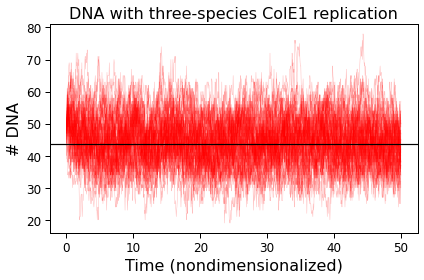

In [24]:
plt.plot(ts, np.array([sim['DNA'] for sim in three_species_bp_results]).T, 
         color = 'red', lw = 0.5, alpha = .25)
plt.axhline(np.mean([sim['DNA'][-100:].mean() for sim in three_species_bp_results]), color = 'black')
plt.title("DNA with three-species ColE1 replication", fontsize = 16)
plt.xlabel("Time (nondimensionalized)", fontsize = 16)
plt.ylabel("# DNA", fontsize = 16)
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "3s_bp_mech_ssa.png"), dpi=300)
plt.show()

# 3) Steady-State Distributions

We can get steady-state distributions by plotting out a bunch of individual trajectories and taking an endpoint snapshot, as before, but then we don't have any kind of selection mechanism to deal with plasmid loss. To handle selection, we'll simulate in a "turbidostat" mode, in which cells grow to a fixed population size, after which every division event also triggers the removal of a cell. To simulate selection against plasmid loss, we'll also use a growth rule that only allows cells to divide when they have at least one DNA species.

We can compare distributions generated by each of the mechanisms. Some of these take a while to run, so we'll cache results in a file `cached_results/default_param_distributions.pkl`. Delete that file if you want to regenerate the simulations fresh. (From here out, most of the simulations we run will be cached; to run a fresh simulation of anything in a call to `simulate_turbidostat_with_caching`, either delete the appropriate cache file in `cached_results/` or change the filename argument to `None`.)

In [25]:
default_trivial_params

{'k_gamma': 1, 'k_alpha': 1}

In [26]:
all_models = dict()

default_init = {"DNA": 50}
all_models['trivial']   = make_trivial_model(default_trivial_params, default_init, lineage = True)
all_models['dummy']     = make_dummy_model(default_dummy_params, default_init, lineage = True)
all_models['bp']        = make_BP_model(bp_nondim_params, default_init, lineage = True)
all_models['3s_bp']     = make_three_species_BP_model(fit_simple_bp_params, default_init, lineage = True)

In [27]:
# We're going to be doing this again with slight variations, so let's wrap this simulation up in a function.
def simulate_turbidostat_models(all_models, t_max, population_cap, n_samples = 40, 
                                initial_cell_number = 1, debug = False):
    all_distributions = dict()
    for model_name, model in all_models.items():
        seed = 42334
        np.random.seed(seed)
        bs.random.py_seed_random(seed)

        loop_start_time = datetime.now()
        print("Simulating distribution of model " + model_name + "...")
        # The trivial model spreads more over time, so worth simulating longer
        # to get more distributional info.
        n_generations = 10 if model_name == "trivial" else t_max
        temp_ts = np.linspace(0, n_generations, 4000)
        sample_times = np.linspace(0, n_generations, n_samples) #<- Lineages doesn't like having too few
                                                        # sample times, don't use just one or two.

        all_distributions[model_name] = bs_lineage.py_SimulateTurbidostat(initial_cell_states = initial_cell_number, 
                                                                          timepoints = temp_ts,
                                                                          sample_times = sample_times,
                                                                          population_cap = population_cap,
                                                                          safe = False, 
                                                                          return_dataframes = False,
                                                                          return_sample_times = False,
                                                                          Model = model, debug = debug)                                                                                  
#                                                                           Model = model, debug = False, profiling = True)
        loop_end_time = datetime.now()
        print(model_name + " execution time: " + str(loop_end_time - loop_start_time))
#         print(f"Reaction counts: {counts}")
    print("Done.")
    return all_distributions

def simulate_turbidostat_with_caching(cache_filename, all_models, t_max, population_cap, 
                                      n_samples = 40, initial_cell_number = 1, debug = False):
    '''Wraps simulate_turbidostat_models, but memoizes the results in a file 
    cached_results/<cache_filename>. If that cache file exists, then the model in it 
    will be used instead of running the simulation again. Delete the cache file to
    run the simulation fresh. 
    '''
    full_cache_filename = os.path.join('cached_results', cache_filename)
    if os.path.isfile(full_cache_filename):
        print(f"Using cached results from file {full_cache_filename}.")
        all_distributions = pickle.load(open(full_cache_filename, 'rb'))
    else:
        all_distributions = simulate_turbidostat_models(all_models, t_max, 
                                                        population_cap = population_cap, 
                                                        n_samples = n_samples, 
                                                        initial_cell_number = initial_cell_number,
                                                        debug = debug)
        pickle.dump(all_distributions, open(full_cache_filename, 'wb'))
    return all_distributions

all_distributions = simulate_turbidostat_with_caching('default_param_distributions.pkl', 
                                                all_models, t_max = 20, population_cap = 64, 
                                                n_samples = 10, debug = False)


Using cached results from file cached_results/default_param_distributions.pkl.


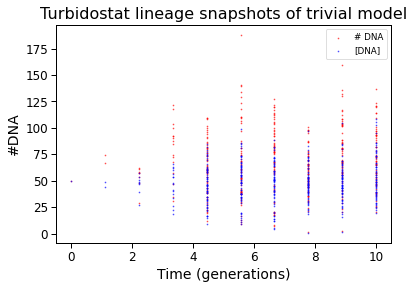

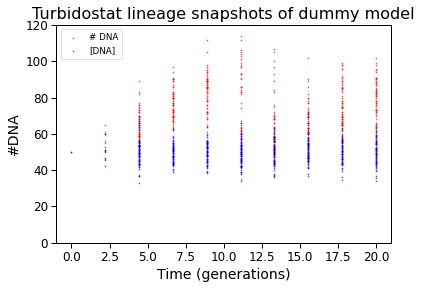

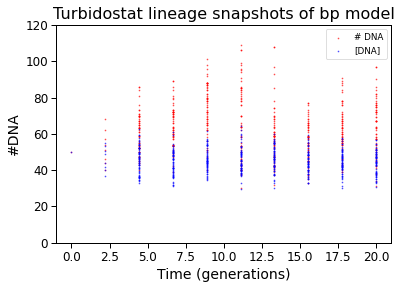

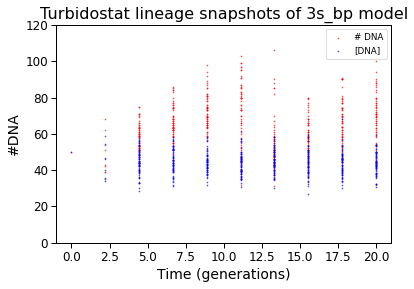

In [28]:
for model in all_models.keys():
    for i, t_slice in enumerate(all_distributions[model]):
        t = t_slice[0].py_get_time()
        dna_idx = all_models[model].get_species2index()["DNA"]
        plt.scatter([t]*len(t_slice), [cs.py_get_state()[dna_idx] for cs in t_slice], 
                    color = 'red', s = 1, alpha = 0.5, label = "# DNA" if i==0 else None)
        plt.scatter([t]*len(t_slice), [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in t_slice], 
                    color = 'blue', s = 1, alpha = 0.5, label = "[DNA]" if i==0 else None)
    if model != "trivial":
        plt.ylim(0, 120)
    plt.xlabel("Time (generations)", fontsize=14)
    plt.ylabel("#DNA", fontsize=14)
    plt.legend()
    plt.title(f"Turbidostat lineage snapshots of {model} model", fontsize=16)
    plt.show()

We can view these as "steady-state" distributions. Note that we're plotting both *copy number* distributions and *concentration* distributions.

In [30]:
def copy_number_distributions_to_dataframe(models, distributions, geometric_resolution = False, include_voigt = False):
    '''
    Converts SimulateTurbidostat results from models with a "DNA" species into a 
    DataFrame of (normalized) copy number counts.
    
    models - a map of <model name> --> <LineageModel object>
    distributions - a map of <model name> --> <list of simulation results from SimulateTurbidostat>
    geometric_resolution - If true, bins on a log scale; otherwise bins into every integer count.
    include_voigt - Iff true, include empirical copy number data from Shao et al. 2021 in the final
                    DataFrame. Voigt data will always be binned linearly.
    '''
    dfs = []
    for model in distributions.keys():
        dna_idx = models[model].get_species2index()["DNA"]
        copy_numbers = np.array([cs.py_get_state()[dna_idx] for cs in distributions[model][-2]])
        highest_count = int(copy_numbers.max())
        if geometric_resolution:
            r = [-.5] + [int(i)-.5 for i in np.geomspace(1, int(highest_count)+2, 30)]
        else:
            r = [i-.5 for i in range(int(highest_count+2))]
        probabilities, hist_edges = np.histogram(copy_numbers, density = True, bins = r)
        dfs.append(pd.DataFrame([[model, hist_edges[i]+0.5, probabilities[i]] for i in range(len(probabilities))], 
                                columns = ["Plasmid", "Copy Number", "Probability"]))
    if include_voigt:
        dfs.append(pd.read_csv(os.path.join("resources", "voigt_extracted_copy_number_data.csv")))
    return pd.concat(dfs)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Steady State Copy Number Distributions')

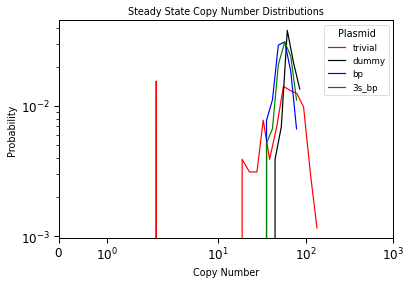

In [31]:
dist_df = copy_number_distributions_to_dataframe(all_models, all_distributions, geometric_resolution = True)
sns.lineplot(data = dist_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
plt.xscale('symlog')
plt.xlim(0, 1e3)
plt.yscale('log')
plt.title("Steady State Copy Number Distributions")
#     axes[1].set_ylim(plasmid_ylim[0], plasmid_ylim[1])

# 4) Fitting Steady-State Distributions to Empirical Data

Are these model distributions at all realistic? Let's compare them to empirical data drawn from Shao *et al* 2021 (https://doi.org/10.1038/s41467-021-21734-y). I pulled this data from Figure 1e using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/), rounding each point to the nearest integer copy number. Those data are tabulated in resources/voigt_extracted_copy_number_data.csv.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Steady State Copy Number Distributions')

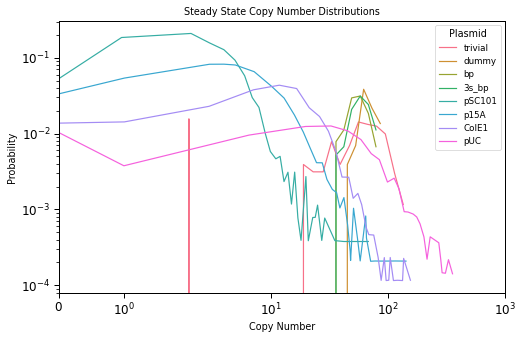

In [32]:

plt.figure(figsize = (8,5))
temp_df = copy_number_distributions_to_dataframe(all_models, all_distributions, 
                                                 geometric_resolution = True, include_voigt = True)
sns.lineplot(data = temp_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
plt.xscale('symlog')
plt.xlim(0, 1e3)
plt.yscale('log')
plt.title("Steady State Copy Number Distributions")

Our modeled distributions are the ones way out on the right -- clearly they're too high copy-number. 

As a first pass at improving fits, let's naively turn down copy numbers by ad-hoc changing parameters, just to get a sense of whether these models' copy number distributions are anywhere in the right ballpark with decent parameters. Also, from here out, we're going to abandon the trivial replication model, since it's unstable and technically doesn't have a steady state distribution aside from "everything has no plasids".

In [33]:
for k, v in fit_simple_bp_params.items():
    print(f"{k}: {v}")

k_rep: 16.126456550542496
k_tx: 275.32994066976653
k_I: 0.6957783093501168
k_p: 33.33018655830395
k_gamma_I: 14.327572665618458
k_gamma: 1


In [34]:
hand_tuned_dummy_params = {
    'k_gamma': 1,
    'k_alpha': 20,
    'k_fast': 100
}

hand_tuned_bp_params = copy.deepcopy(bp_nondim_params)
# hand_tuned_bp_params['k_gamma_I'] = hand_tuned_bp_params['k_gamma_I'] / 2.5
hand_tuned_bp_params['k_1'] *= 3

hand_tuned_simple_bp_params = copy.deepcopy(fit_simple_bp_params)
# hand_tuned_simple_bp_params['k_gamma_I'] = hand_tuned_simple_bp_params['k_gamma_I'] / 2.5
hand_tuned_simple_bp_params['k_p'] /= 3

hand_tuned_models = dict()
hand_tuned_models['dummy']     = make_dummy_model(hand_tuned_dummy_params, default_init, lineage = True)
hand_tuned_models['bp']        = make_BP_model(hand_tuned_bp_params, default_init, lineage = True)
hand_tuned_models['3s_bp'] = make_three_species_BP_model(hand_tuned_simple_bp_params, default_init, lineage = True)

hand_tuned_distributions = simulate_turbidostat_with_caching('hand_tuned_results.pkl', 
                                                             hand_tuned_models, t_max = 18,
                                                             population_cap = 256, n_samples = 5,
                                                             debug = False)


Using cached results from file cached_results/hand_tuned_results.pkl.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Copy Number Distributions, Hand-Tuned')

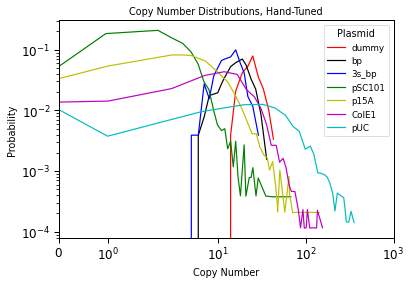

In [35]:
temp_hand_tuned_df = copy_number_distributions_to_dataframe(hand_tuned_models, hand_tuned_distributions, 
                                                 geometric_resolution = True, include_voigt = True)
sns.lineplot(data = temp_hand_tuned_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
plt.xscale('symlog')
plt.xlim(0, 1e3)
plt.yscale('log')
plt.title("Copy Number Distributions, Hand-Tuned")

Now this again, but with all parameters except dilution rate turned down 5x:

In [36]:
slowdown_factor = 5

slow_dummy_params = copy.deepcopy(hand_tuned_dummy_params)
for param in slow_dummy_params:
    slow_dummy_params[param] /= slowdown_factor

slow_bp_params = copy.deepcopy(hand_tuned_bp_params)
for param in slow_bp_params:
    slow_bp_params[param] /= slowdown_factor

slow_simple_bp_params = copy.deepcopy(hand_tuned_simple_bp_params)
for param in slow_simple_bp_params:
    slow_simple_bp_params[param] /= slowdown_factor

hand_tuned_slow_models = dict()
hand_tuned_slow_models['dummy']     = make_dummy_model(slow_dummy_params, default_init, lineage = True)
hand_tuned_slow_models['bp']        = make_BP_model(slow_bp_params, default_init, lineage = True)
hand_tuned_slow_models['3s_bp']     = make_three_species_BP_model(slow_simple_bp_params, default_init, lineage = True)

# DEV EYES HERE
###
# CHANGE t_max to 20 (and delete this comment) when done testing stuff!
###
hand_tuned_slow_distributions = simulate_turbidostat_with_caching('hand_tuned_slow_results.pkl', 
                                                             hand_tuned_slow_models, t_max = 80, 
                                                             population_cap = 256, n_samples = 5)


Using cached results from file cached_results/hand_tuned_slow_results.pkl.


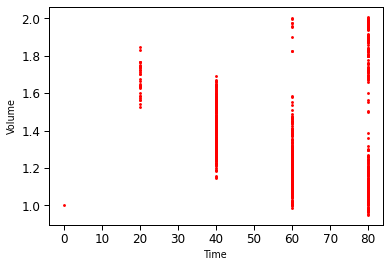

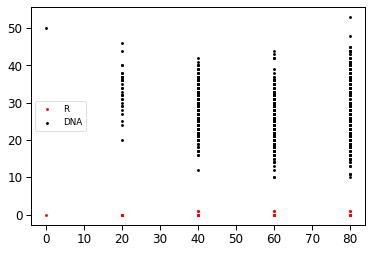

In [37]:
data = hand_tuned_slow_distributions['dummy']
all_states = [cs for state_list in data for cs in state_list ]
neg_states = [cs for cs in all_states if cs.py_get_volume() <= 0]
plt.scatter([cs.py_get_time() for cs in all_states], [cs.py_get_volume() for cs in all_states], s = 4)
plt.xlabel("Time") 
plt.ylabel("Volume")
# plt.xlim(49, 51)
plt.show()

plt.scatter([cs.py_get_time() for cs in all_states], [cs.py_get_state()[0] for cs in all_states], s = 4, label = "R")
plt.scatter([cs.py_get_time() for cs in all_states], [cs.py_get_state()[1] for cs in all_states], s = 4, label = "DNA")
plt.legend()
# plt.xlim(49, 51)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Copy Number Distributions, Hand-Tuned (slowed)')

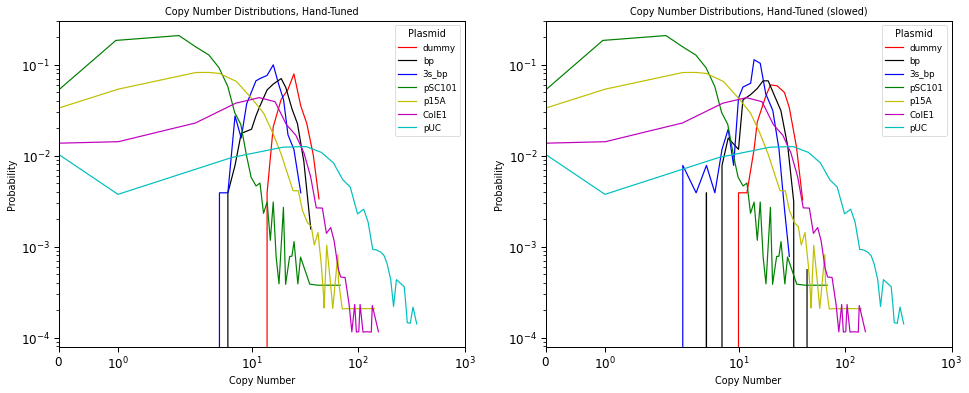

In [38]:
plt.figure(figsize = (16, 6))
temp_slow_df = copy_number_distributions_to_dataframe(hand_tuned_slow_models, hand_tuned_slow_distributions, 
                                                 geometric_resolution = True, include_voigt = True)

plt.subplot(121)
sns.lineplot(data = temp_hand_tuned_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
plt.xscale('symlog')
plt.xlim(0, 1e3)
plt.yscale('log')
plt.title("Copy Number Distributions, Hand-Tuned")

plt.subplot(122)
sns.lineplot(data = temp_slow_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
plt.xscale('symlog')
plt.xlim(0, 1e3)
plt.yscale('log')
plt.title("Copy Number Distributions, Hand-Tuned (slowed)")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Copy Number Distributions, Hand-Tuned')

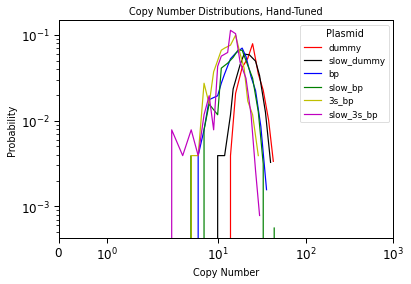

In [39]:
all_hand_tuned_models = dict()
all_hand_tuned_distributions = dict()
for m_name in hand_tuned_models:
    all_hand_tuned_models[m_name] = hand_tuned_models[m_name]
    all_hand_tuned_distributions[m_name] = hand_tuned_distributions[m_name]
    all_hand_tuned_models["slow_" + m_name] = hand_tuned_slow_models[m_name]
    all_hand_tuned_distributions["slow_" + m_name] = hand_tuned_slow_distributions[m_name]    
all_hand_tuned_df = copy_number_distributions_to_dataframe(all_hand_tuned_models, all_hand_tuned_distributions, 
                                                 geometric_resolution = True, include_voigt = False)

sns.lineplot(data = all_hand_tuned_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
plt.xscale('symlog')
plt.xlim(0, 1e3)
plt.yscale('log')
plt.title("Copy Number Distributions, Hand-Tuned")

This is, at the very least, a better starting place for parameter optimization.

Rigorously fitting to the whole distribution is rather difficult, for computational reasons (fitting functions with stochastic output is, in general, difficult, and each simulation of the B&P model takes a long time!). To begin with, instead of fitting distribution curves directly against empirical data, let's just fit parameters so that a deterministic simulation produces copy numbers matching the mean copy number from empirical data. We'll do this for each empirically measured plasmid backbone, starting from the hand-tuned parameters above.

Now, the deterministic ODE simulations we can run for each model report plasmids in terms of *concentration*, not copy number -- to convert to copy number, we need to know an average cell volume. We can get (an estimate of) this from the lineage simulations immediately above:

In [40]:
last_slices = [hand_tuned_distributions[model][-2] for model in hand_tuned_distributions.keys()]
last_slice_volumes = [last_slice[i].py_get_volume() for last_slice in last_slices for i in range(len(last_slice))]
estimated_average_volume = sum(last_slice_volumes)/len(last_slice_volumes)
print(f"Volume, estimated from last time points of hand-tuned model simulations: {estimated_average_volume}")

Volume, estimated from last time points of hand-tuned model simulations: 1.3030340845780823


Now we can optimize.

In [41]:
voigt_df = pd.read_csv(os.path.join("resources", "voigt_extracted_copy_number_data.csv"))
temp_ts = np.linspace(0, 200, 500)
model_setup_funcs = {
    'dummy': lambda params: make_dummy_model(params, {"DNA":50}, lineage = False),
    'bp': lambda params: make_BP_model(params, {"DNA":50}, lineage = False),
    '3s_bp': lambda params: make_three_species_BP_model(params, {"DNA":50}, lineage = False),
}

model_default_params = {
    'dummy': copy.deepcopy(hand_tuned_dummy_params),
    'bp': copy.deepcopy(hand_tuned_bp_params),
    '3s_bp': copy.deepcopy(hand_tuned_simple_bp_params),
}
for k in model_default_params.keys():
    del model_default_params[k]['k_gamma']

dna_species = {
    'dummy': ['DNA'],
    'bp': ["DNA", "DNA_RIIs", "DNA_RIIL", "DNA_p", "DNA_II_Iu", "DNA_II_Is"],
    '3s_bp': ['DNA', 'DNAp'],
}

mean_copy_nums = dict()

loop_start_time = datetime.now()
mean_fit_params = {plasmid: dict() for plasmid in voigt_df.Plasmid.unique()}
for plasmid in voigt_df.Plasmid.unique():
    plas_df = voigt_df[voigt_df.Plasmid == plasmid]
    mean_copy_num = np.average(plas_df["Copy Number"], weights = plas_df.Probability)
    mean_concentration = mean_copy_num / estimated_average_volume
    mean_copy_nums[plasmid] = mean_copy_num
    print(f"Optimizing for plasmid {plasmid}...")
    for model_name in ['dummy', 'bp', '3s_bp']:
        print(f"\tOptimizing model {model_name} to {mean_copy_num} copy number ({mean_concentration} concentration)... ", end = "")
        param_default_dict = model_default_params[model_name]
        param_names = list(param_default_dict.keys())
        def model_error(params):
            if np.any(np.isnan(params)):
                print(f"Bad parameter set for {model_name}: {params}")
                return np.inf
            param_dict = {param_names[i]: params[i] for i in range(len(params))}
            param_dict['k_gamma'] = 1 # dilution rate is fixed to 1 generation time
            m = model_setup_funcs[model_name](param_dict)
            temp_results = bs.simulator.py_simulate_model(temp_ts, Model = m, stochastic = False)
            # Optimizing for steady state value near true mean.
            dna_series = list(temp_results[[col for col in temp_results.columns if col in dna_species[model_name]]].sum(axis=1))
            return abs(dna_series[-3] - mean_concentration)
        param_defaults = [param_default_dict[n] for n in param_names]
        results = scipy.optimize.minimize(model_error, param_defaults, method = 'TNC',
                                          options = {'ftol': 1e-14, 'xtol': 1e-10},
                                          bounds = [(0, None) for i in range(len(param_names))])
        print(results.message)     
        mean_fit_params[plasmid][model_name] = {param_names[i]: results.x[i] for i in range(len(results.x))}#results.x
        mean_fit_params[plasmid][model_name]['k_gamma'] = 1
loop_end_time = datetime.now()
print("Optimization execution time: " + str(loop_end_time - loop_start_time))

Optimizing for plasmid pSC101...
	Optimizing model dummy to 3.490302561341606 copy number (2.678596517658825 concentration)... Converged (|x_n-x_(n-1)| ~= 0)
	Optimizing model bp to 3.490302561341606 copy number (2.678596517658825 concentration)... 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Linear search failed
	Optimizing model 3s_bp to 3.490302561341606 copy number (2.678596517658825 concentration)... Converged (|x_n-x_(n-1)| ~= 0)
Optimizing for plasmid p15A...
	Optimizing model dummy to 7.195215224182611 copy number (5.521893332907247 concentration)... Linear search failed
	Optimizing model bp to 7.195215224182611 copy number (5.521893332907247 concentration)... Converged (|x_n-x_(n-1)| ~= 0)
	Optimizing model 3s_bp to 7.195215224182611 copy number (5.521893332907247 concentration)... Converged (|x_n-x_(n-1)| ~= 0)
Optimizing for plasmid ColE1...
	Optimizing model dummy to 15.53773091224893 copy number (11.92427051306182 concentration)... Linear search failed
	Optimizing model bp to 15.53773091224893 copy number (11.92427051306182 concentration)... Converged (|x_n-x_(n-1)| ~= 0)
	Optimizing model 3s_bp to 15.53773091224893 copy number (11.92427051306182 concentration)... Converged (|x_n-x_(n-1)| ~= 0)
Optimizing for plasmid pUC...
	Optimizing model dummy to 49.4548740

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


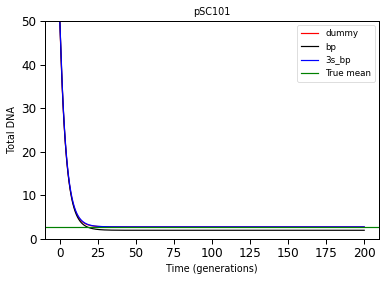

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


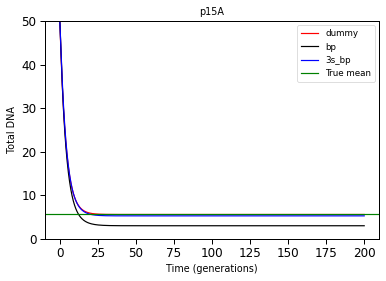

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


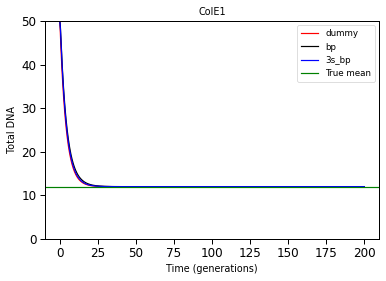

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


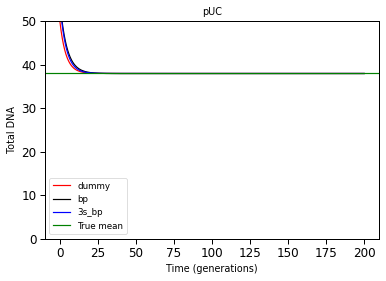

In [42]:
for plasmid in voigt_df.Plasmid.unique():
    temp_models = dict()
    for model_name in ['dummy', 'bp', '3s_bp']:
        param_names = list(model_default_params[model_name].keys())
        temp_models[model_name] = model_setup_funcs[model_name](mean_fit_params[plasmid][model_name])
        det_results = bs.simulator.py_simulate_model(np.linspace(0, 50, 500), Model = temp_models[model_name])
        plt.plot(temp_ts, det_results[[col for col in det_results.columns if col in dna_species[model_name]]].sum(axis=1), label = model_name)
    plt.axhline(mean_copy_nums[plasmid]/estimated_average_volume, color = "green", label = "True mean")
    plt.title(plasmid)
    plt.xlabel("Time (generations)")
    plt.ylabel("Total DNA")
    plt.ylim(0, 50)
    plt.legend()
    plt.show()

In [43]:
import json
print(json.dumps(mean_fit_params,sort_keys=True, indent=4))

{
    "ColE1": {
        "3s_bp": {
            "k_I": 0.7395327627476121,
            "k_gamma": 1,
            "k_gamma_I": 14.160863512625529,
            "k_p": 10.945097467978279,
            "k_rep": 15.92595858957828,
            "k_tx": 278.4433246584664
        },
        "bp": {
            "k_1": 24.75238956969227,
            "k_2": 1903.078781492698,
            "k_D": 216.3348964594768,
            "k_I": 259.97425100574725,
            "k_II": 10.663316631568,
            "k_L": 517.8425567875352,
            "k_gamma": 1,
            "k_gamma_I": 15.119618257794093,
            "k_m1": 2075.4106416546374,
            "k_m2": 3.687497101206103,
            "k_mC": 735.5688646251322,
            "k_mL": 186.22133197200162,
            "k_p": 184.94558162013402
        },
        "dummy": {
            "k_alpha": 11.924270510813908,
            "k_fast": 100.00829573808856,
            "k_gamma": 1
        }
    },
    "p15A": {
        "3s_bp": {
            "k_I": 1.0910

Now let's see how well those (mean-only optimized) parameters are at generating well-fit distributions.

**Warning**: These can take quite a while to run, depending on your computer. To save time and let you run the rest of the notebook, we've cached results of a run in a file "cached_results/mean_tuned_distributions.pkl" (and the models for those results in a similarly-named file). If you want to run these simulations again, delete that file before you run this code block; be warned that you'll be waiting a while.

Alert! Using cached results for at least one simulation to save time. Delete file cached_results/mean_tuned_distributions.pkl to re-run simulations.


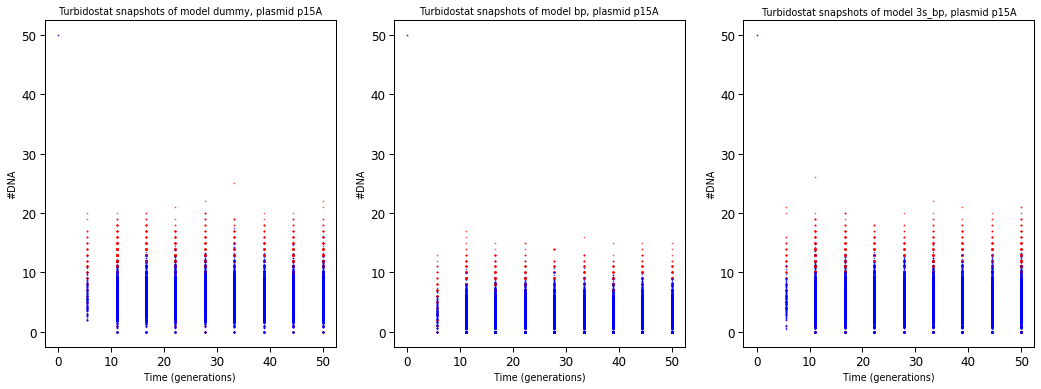

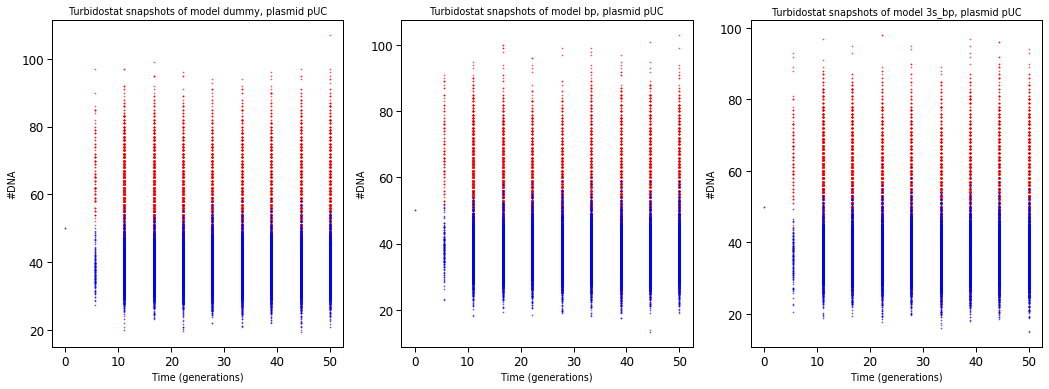

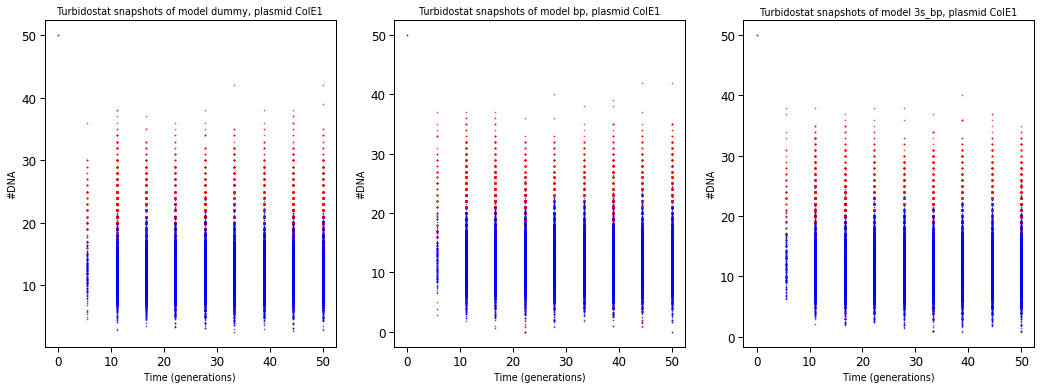

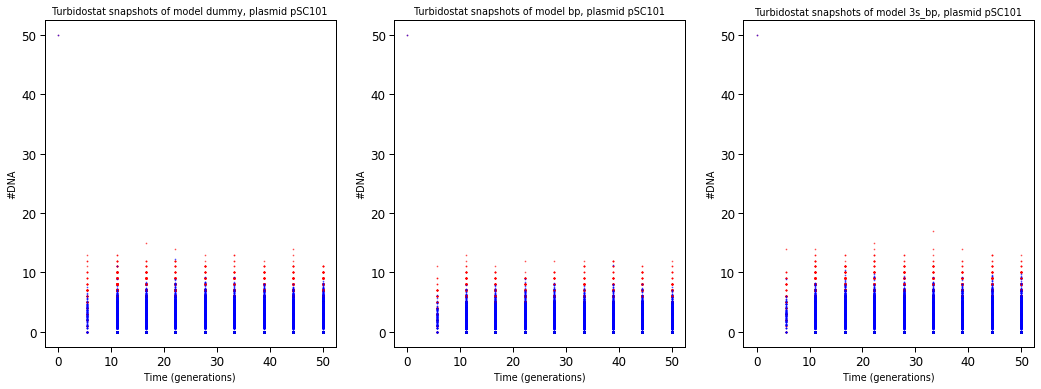

In [44]:
lineage_model_setup_funcs = {
    'dummy': make_dummy_model,
    'bp': make_BP_model,
    '3s_bp': make_three_species_BP_model,
}
model_names = lineage_model_setup_funcs.keys()

cached_model_filename = os.path.join('cached_results', 'mean_tuned_models.pkl')
model_is_cached = os.path.isfile(cached_model_filename)
if model_is_cached:
    mean_tuned_models = pickle.load(open(cached_model_filename, 'rb'))
else:
    mean_tuned_models = dict()
    
cached_results_filename = os.path.join('cached_results', 'mean_tuned_distributions.pkl')
results_are_cached = os.path.isfile(cached_results_filename)
if results_are_cached:
    mean_tuned_distributions = pickle.load(open(cached_results_filename, 'rb'))
    print(f"Alert! Using cached results for at least one simulation to save time. Delete file {cached_results_filename} to re-run simulations.")
else:
    mean_tuned_distributions = dict()
    
for plasmid in ['p15A', 'pUC', 'ColE1', 'pSC101']:
    inits = {"DNA": mean_copy_nums[plasmid]}
    mean_tuned_models = {model_name: lineage_model_setup_funcs[model_name](mean_fit_params[plasmid][model_name], inits, lineage = True) for model_name in model_names}
    if plasmid in mean_tuned_distributions.keys():
        models_to_sim = {model_name:mean_tuned_models[model_name] for model_name in model_names if model_name not in mean_tuned_distributions[plasmid].keys()}
    else:
        models_to_sim = mean_tuned_models
        mean_tuned_distributions[plasmid] = dict()

    if True:
        if len(models_to_sim) > 0:
            print(f"Simulating stochastic distributions for plasmid {plasmid}")
            mean_tuned_distributions[plasmid].update(simulate_turbidostat_models(models_to_sim, 
                                                                                 t_max = 50, 
                                                                                 population_cap = 2048, 
                                                                                 n_samples = 10))
        plt.figure(figsize = (24,6))
        for i, model in enumerate(model_names):
            plt.subplot(1, 4, i+1)
            for i, t_slice in enumerate(mean_tuned_distributions[plasmid][model]):
                t = t_slice[0].py_get_time()
                dna_idx = mean_tuned_models[model].get_species2index()["DNA"]
                plt.scatter([t]*len(t_slice), [cs.py_get_state()[dna_idx] for cs in t_slice], 
                            color = 'red', s = 1, alpha = 0.5, label = "# DNA" if i==0 else None)
                plt.scatter([t]*len(t_slice), [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in t_slice], 
                            color = 'blue', s = 1, alpha = 0.5, label = "[DNA]" if i==0 else None)
            plt.xlabel("Time (generations)")
            plt.ylabel("#DNA")
            plt.title(f"Turbidostat snapshots of model {model}, plasmid {plasmid}")
        plt.show()
    
        pickle.dump(mean_tuned_models, open(os.path.join('cached_results', 'mean_tuned_models.pkl'), 'wb'))
        pickle.dump(mean_tuned_distributions, open(os.path.join('cached_results', 'mean_tuned_distributions.pkl'), 'wb'))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


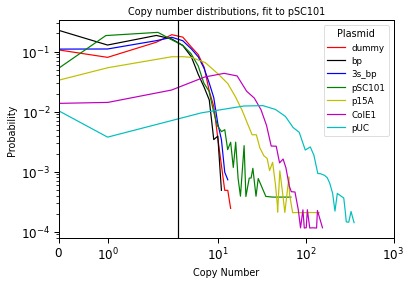

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


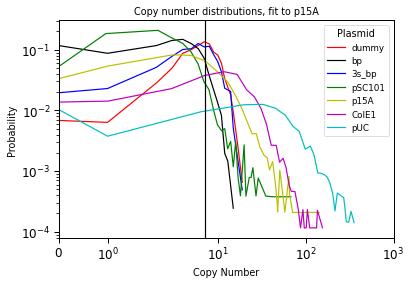

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


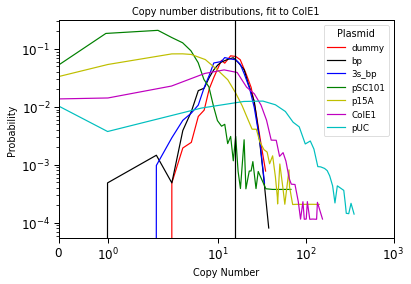

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


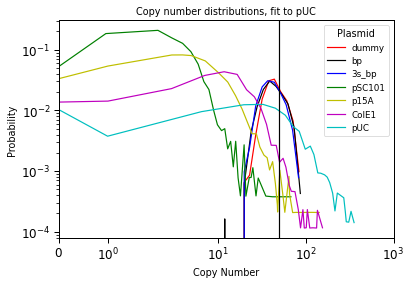

In [45]:
all_mean_tuned_models = dict()
for plasmid in voigt_df.Plasmid.unique():
    inits = {"DNA": mean_copy_nums[plasmid]}
    mean_tuned_models[plasmid] = {model_name: lineage_model_setup_funcs[model_name](mean_fit_params[plasmid][model_name], inits, lineage = True)\
                                  for model_name in model_names}
    temp_df = copy_number_distributions_to_dataframe(mean_tuned_models[plasmid], mean_tuned_distributions[plasmid], 
                                                 geometric_resolution = True, include_voigt = True)
    sns.lineplot(data = temp_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
    plt.axvline(mean_copy_nums[plasmid], color = 'black', label = "empirical mean")
    plt.xscale('symlog')
    plt.xlim(0, 1e3)
    plt.yscale('log')
    plt.title(f"Copy number distributions, fit to {plasmid}")
    plt.show()

For comparison, here's the time to run the three-species BP models with and without a quasi-steady-state assumption on $R$:

Simulating distribution of model no_qss_assumption...
no_qss_assumption execution time: 0:00:01.881048
Simulating distribution of model qss_assumed...
qss_assumed execution time: 0:00:00.763739
Done.
Finished in 1 iterations.
Highest: DNA: 9.0; DNAp: 2.0; R: 262.0
Highest: DNA: 11.0; DNAp: 2.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


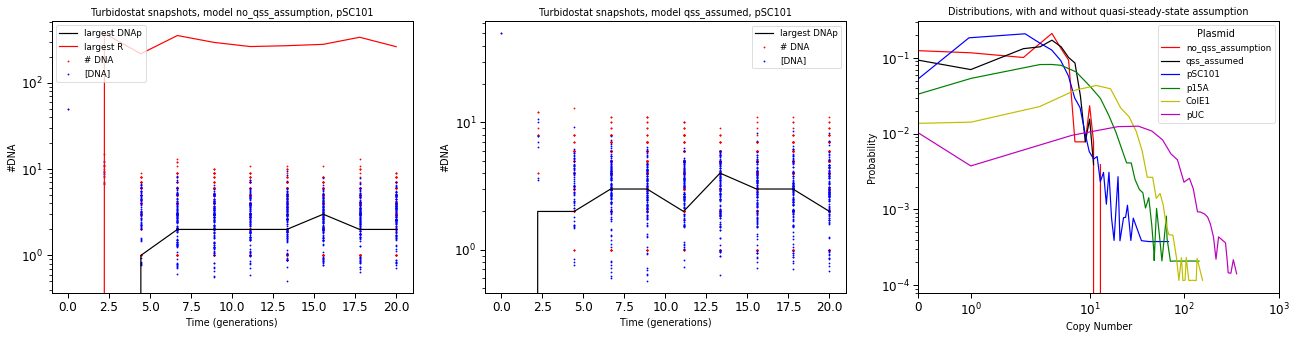

Simulating distribution of model no_qss_assumption...
no_qss_assumption execution time: 0:00:01.775307
Simulating distribution of model qss_assumed...
qss_assumed execution time: 0:00:00.550673
Done.
Finished in 1 iterations.
Highest: DNA: 16.0; DNAp: 2.0; R: 344.0
Highest: DNA: 13.0; DNAp: 3.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


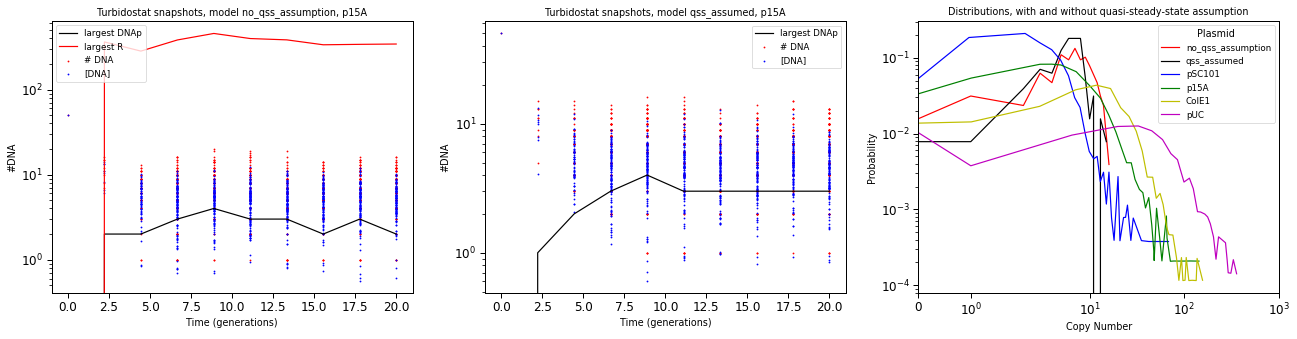

Simulating distribution of model no_qss_assumption...
no_qss_assumption execution time: 0:00:03.683703
Simulating distribution of model qss_assumed...
qss_assumed execution time: 0:00:00.410362
Done.
Finished in 1 iterations.
Highest: DNA: 32.0; DNAp: 6.0; R: 581.0
Highest: DNA: 29.0; DNAp: 5.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


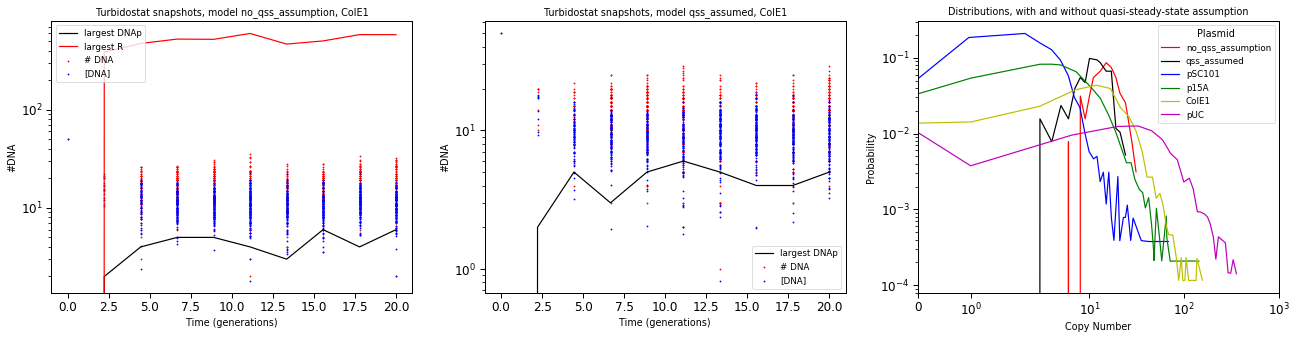

Simulating distribution of model no_qss_assumption...
no_qss_assumption execution time: 0:00:08.752611
Simulating distribution of model qss_assumed...
qss_assumed execution time: 0:00:01.053545
Done.
Finished in 1 iterations.
Highest: DNA: 76.0; DNAp: 10.0; R: 1147.0
Highest: DNA: 67.0; DNAp: 7.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


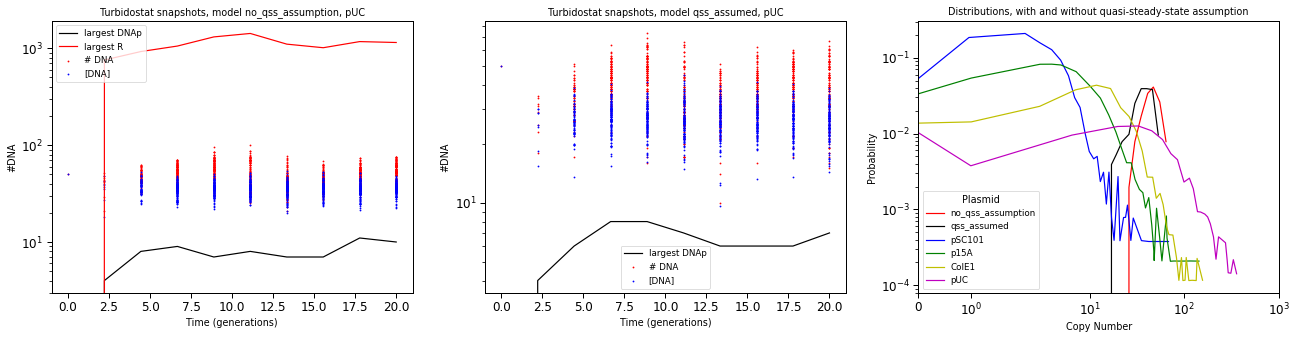

In [48]:
import warnings
for plasmid in voigt_df.Plasmid.unique():
    three_species_bp_models = {
        "no_qss_assumption": make_three_species_BP_model(mean_fit_params[plasmid]['3s_bp'], 
                                                         default_init, lineage = True),
        "qss_assumed": make_qss_three_species_BP_model(mean_fit_params[plasmid]['3s_bp'], 
                                                        default_init, lineage = True, 
                                                        force_approximation = False, verbose = True)
    }

    with warnings.catch_warnings():
        warnings.simplefilter("error")
        i = 1
        while i <= 10:
            try:
                bp_results = simulate_turbidostat_models(three_species_bp_models, t_max = 20, population_cap = 128, n_samples = 10)
                break
            except:
                print("Running again.")
                i += 1
    print(f"Finished in {i} iterations.")

    plt.figure(figsize = (22,5))
    for idx, model in enumerate(three_species_bp_models.keys()):
        dna_idx = three_species_bp_models[model].get_species2index()["DNA"]
        dnap_idx = three_species_bp_models[model].get_species2index()["DNAp"]
        if model == "no_qss_assumption":
            r_idx = three_species_bp_models[model].get_species2index()["R"]
        plt.subplot(1, 3, idx+1)
        for i, t_slice in enumerate(bp_results[model]):
            t = t_slice[0].py_get_time()
            
            plt.scatter([t]*len(t_slice), [cs.py_get_state()[dna_idx] for cs in t_slice], 
                        color = 'red', s = 1, alpha = 1, label = "# DNA" if i==0 else None)
            plt.scatter([t]*len(t_slice), [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in t_slice], 
                        color = 'blue', s = 1, alpha = 1, label = "[DNA]" if i==0 else None)
        ts = [t_slice[0].py_get_time() for t_slice in bp_results[model]]
        plt.plot(ts, [max([cs.py_get_state()[dnap_idx] for cs in bp_results[model][i]]) for i in range(len(bp_results[model]))],
                 label = "largest DNAp", color = 'black')
        if model == "no_qss_assumption":
            plt.plot(ts, [max([cs.py_get_state()[r_idx] for cs in bp_results[model][i]]) for i in range(len(bp_results[model]))],
                     label = "largest R", color = 'red')
        plt.xlabel("Time (generations)")
        plt.ylabel("#DNA")
        plt.title(f"Turbidostat snapshots, model {model}, {plasmid}")
        max_dna = max([cs.py_get_state()[dna_idx] for cs in bp_results[model][-1]])
        max_dnap = max([cs.py_get_state()[dnap_idx] for cs in bp_results[model][-1]])
        r_str = f"; R: {max([cs.py_get_state()[r_idx] for cs in bp_results[model][-1]])}"\
                if model == "no_qss_assumption" else ""
        print(f"Highest: DNA: {max_dna}; DNAp: {max_dnap}{r_str}")
        plt.legend()
        plt.yscale('log')
    plt.subplot(1,3,3)
    temp_df = copy_number_distributions_to_dataframe(three_species_bp_models, bp_results, 
                                                 geometric_resolution = True, include_voigt = True)
    sns.lineplot(data = temp_df, x = "Copy Number", y = "Probability", hue = "Plasmid")
    plt.title("Distributions, with and without quasi-steady-state assumption")
    plt.xscale('symlog')
    plt.xlim(0, 1e3)
    plt.yscale('log')
    plt.show()